In [2]:
import pandas as pd
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# **ETAPA 1: CARREGAMENTO E LIMPEZA**

In [3]:
# Carregar dados do arquivo local (150 registros)
with open('../data/hubfolio_mock_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.json_normalize(data)

df = df.rename(columns={
    'secoes_preenchidas.bio': 'bio',
    'secoes_preenchidas.projetos_min': 'projetos_min',
    'secoes_preenchidas.habilidades_min': 'habilidades_min',
    'secoes_preenchidas.contatos': 'contatos',
    'palavras_chave_clareza.contexto': 'kw_contexto',
    'palavras_chave_clareza.processo': 'kw_processo',
    'palavras_chave_clareza.resultado': 'kw_resultado'
})

print("--- Dados Carregados e Achatados ---")
print(df.head())
print(f"\n--- Total de registros: {len(df)} ---")
print("\n--- Informações e Tipos de Dados ---")
df.info()

--- Dados Carregados e Achatados ---
   user_id                 nome  consistencia_visual_score   bio  \
0       41  Gustavo Lewandowski                         41  True   
1        4        Augusto Silva                         60  True   
2       56      Renata Phillips                         79  True   
3      146       Letícia Rangel                         84  True   
4       74            Zion Melo                         40  True   

   projetos_min  habilidades_min  contatos  kw_contexto  kw_processo  \
0             6               15     False            1            3   
1             5               20      True            1            1   
2             5               10      True            0            2   
3             1                8     False            2            4   
4             3                7      True            3            3   

   kw_resultado  
0             5  
1             1  
2             1  
3             2  
4             3  

--- Total de

# **ETAPA 2: ENGENHARIA DE FEATURES (Cálculo das Métricas)**

In [4]:
# Métrica 1: Completude (0-100%)
# Assumindo 4 seções principais, 25% cada.
# Requisitos: bio=True, projetos_min>=1, habilidades_min>=5, contatos=True
df['completude_score'] = (
    (df['bio'].astype(int) * 25) +
    ((df['projetos_min'] >= 1).astype(int) * 25) +
    ((df['habilidades_min'] >= 5).astype(int) * 25) +
    (df['contatos'].astype(int) * 25)
)

# Métrica 2: Clareza (0-100%)
# Assumindo que um score "perfeito" teria 5 de cada palavra-chave (total 15)
df['total_palavras_chave'] = df['kw_contexto'] + df['kw_processo'] + df['kw_resultado']
max_palavras_chave_esperado = 15  # Teto definido pela equipe
df['clareza_score'] = (df['total_palavras_chave'] / max_palavras_chave_esperado) * 100
df['clareza_score'] = df['clareza_score'].clip(0, 100) # Garante que não passe de 100%

# Métrica 3: Índice de Qualidade (IQ) (0-100)
# Fórmula ponderada definida pelo projeto: 40% completude, 40% clareza, 20% visual
df['indice_qualidade'] = (
    (df['completude_score'] * 0.4) +
    (df['clareza_score'] * 0.4) +
    (df['consistencia_visual_score'] * 0.2)
)

print("\n--- Métricas Calculadas ---")
print(df[['nome', 'completude_score', 'clareza_score', 'consistencia_visual_score', 'indice_qualidade']])


--- Métricas Calculadas ---
                    nome  completude_score  clareza_score  \
0    Gustavo Lewandowski                75      60.000000   
1          Augusto Silva               100      20.000000   
2        Renata Phillips               100      20.000000   
3         Letícia Rangel                75      53.333333   
4              Zion Melo               100      60.000000   
..                   ...               ...            ...   
145         Micaela Hill                50      40.000000   
146         Tales Nelson               100      26.666667   
147       Charlie Macedo               100      60.000000   
148      Priscila Araújo                50      26.666667   
149      Daniela Salazar                75      60.000000   

     consistencia_visual_score  indice_qualidade  
0                           41         62.200000  
1                           60         60.000000  
2                           79         63.800000  
3                           84    

# **ETAPA 3: NOTEBOOK ANALÍTICO (Análise Exploratória - EDA)**


--- Análise Descritiva das Métricas ---
       completude_score  clareza_score  indice_qualidade
count        150.000000     150.000000        150.000000
mean          77.333333      44.222222         62.080889
std           21.352480      21.016902         14.040023
min            0.000000       0.000000         11.066667
25%           75.000000      26.666667         54.883333
50%           75.000000      40.000000         62.466667
75%          100.000000      60.000000         70.283333
max          100.000000     100.000000         99.000000


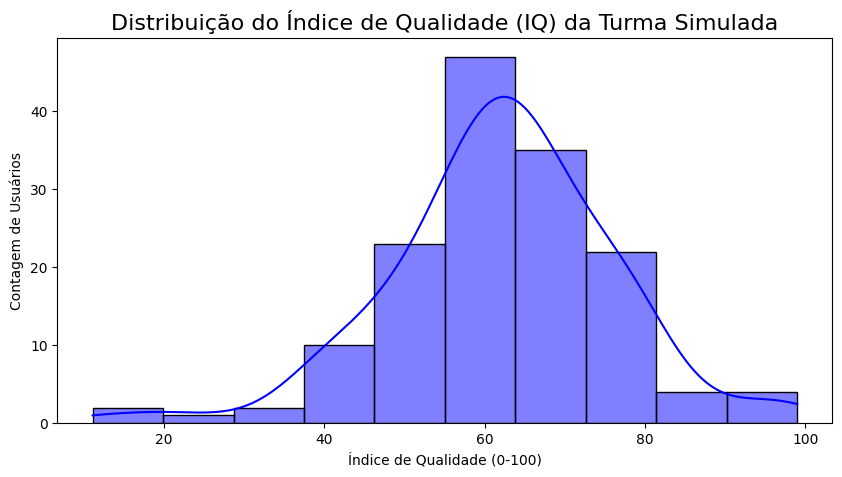

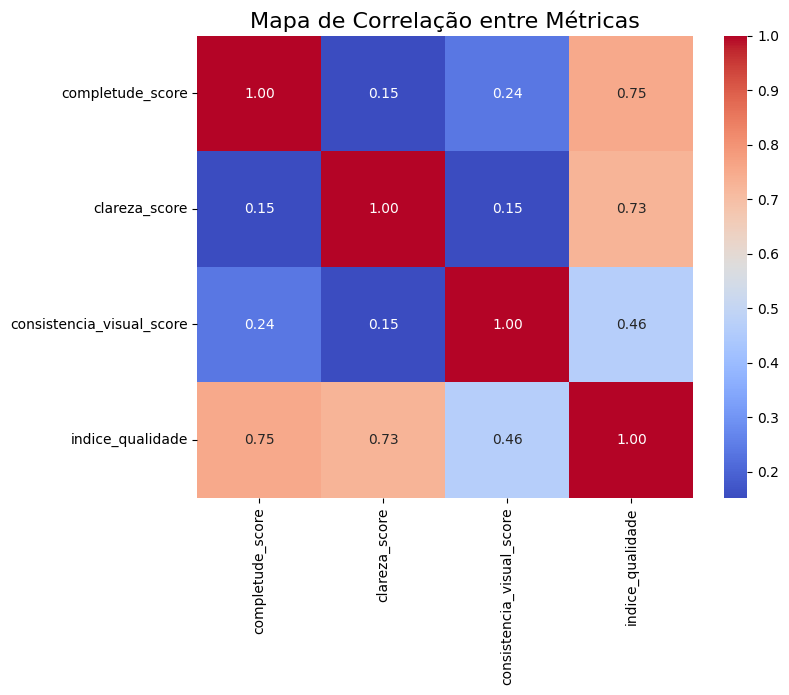

In [5]:
print("\n--- Análise Descritiva das Métricas ---")
print(df[['completude_score', 'clareza_score', 'indice_qualidade']].describe())

# Gráfico 1: Distribuição do Índice de Qualidade (IQ)
plt.figure(figsize=(10, 5))
sns.histplot(df['indice_qualidade'], kde=True, bins=10, color='blue')
plt.title('Distribuição do Índice de Qualidade (IQ) da Turma Simulada', fontsize=16)
plt.xlabel('Índice de Qualidade (0-100)')
plt.ylabel('Contagem de Usuários')
plt.show()

# Gráfico 2: Correlação entre as métricas base
# Esperamos alta correlação entre 'clareza'/'completude' e o IQ, pois são seus componentes
plt.figure(figsize=(8, 6))
correlation_matrix = df[['completude_score', 'clareza_score', 'consistencia_visual_score', 'indice_qualidade']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Correlação entre Métricas', fontsize=16)
plt.show()

# **ETAPA 4: VIABILIDADE TÉCNICA (Técnicas de ML)**

In [6]:
# Objetivo: Provar que podemos prever o 'indice_qualidade' (y)
# usando os DADOS BRUTOS (X) que o usuário insere.

# Definir Features (X) e Target (y)
features = [
    'projetos_min', 'habilidades_min',
    'kw_contexto', 'kw_processo', 'kw_resultado',
    'consistencia_visual_score',
    'bio', 'contatos'
]

X = df[features].astype(float) # Converter tudo para numérico para o modelo
y = df['indice_qualidade']

# Dividir dados para treino e teste
# Com 10 amostras, é apenas uma prova de conceito. O ideal seria ter mais dados.
# Usaremos 30% para teste (3 amostras)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"\n--- Treinamento de ML (Prova de Conceito) ---")
print(f"Total de amostras: {len(X)}")
print(f"Amostras de Treino: {len(X_train)}, Amostras de Teste: {len(X_test)}")

# Treinar o modelo de Regressão Linear
model = LinearRegression()
model.fit(X_train, y_train)

# Fazer previsões nos dados de teste
y_pred = model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"\nResultado da Previsão (Regressão Linear):")
print(f"RMSE (Erro Médio): {rmse:.2f} pontos de IQ")
print("Valores Reais (Teste):", y_test.values)
print("Valores Previstos (ML):", y_pred)

print("\n--- VIABILIDADE TÉCNICA DE ML COMPROVADA ---")
print("O modelo consegue aprender a relação entre os inputs brutos e o score final.")


--- Treinamento de ML (Prova de Conceito) ---
Total de amostras: 150
Amostras de Treino: 105, Amostras de Teste: 45

Resultado da Previsão (Regressão Linear):
RMSE (Erro Médio): 5.13 pontos de IQ
Valores Reais (Teste): [46.33333333 61.66666667 87.6        47.         80.6        74.73333333
 52.46666667 56.33333333 66.26666667 62.6        65.26666667 75.06666667
 65.46666667 49.46666667 63.46666667 66.4        52.8        79.53333333
 61.13333333 46.73333333 59.4        79.         61.33333333 57.53333333
 52.53333333 47.8        71.86666667 55.8        49.73333333 78.
 74.6        75.46666667 40.53333333 67.73333333 72.4        67.46666667
 68.26666667 11.06666667 72.         63.73333333 79.66666667 70.
 65.33333333 96.13333333 63.2       ]
Valores Previstos (ML): [ 46.32009585  53.23387665  83.55119787  42.87983909  76.33802225
  69.78608503  52.53115441  59.56133859  60.32343538  62.59640048
  67.71654241  73.38903438  66.11448535  45.08649622  62.72612129
  61.8811428   55.0389741

# **ETAPA 5: COMPARAÇÃO DE MODELOS DE ML**

Nesta etapa, vamos treinar e comparar **3 modelos diferentes** para prever o Índice de Qualidade:
1. **Regressão Linear** (baseline)
2. **Árvore de Decisão** (Decision Tree Regressor)
3. **K-Nearest Neighbors (KNN)**

Vamos avaliar usando múltiplas métricas e visualizações comparativas.

In [7]:
# ========================================
# 1. TREINAMENTO DOS TRÊS MODELOS
# ========================================

print("="*60)
print("TREINANDO E COMPARANDO MÚLTIPLOS MODELOS DE ML")
print("="*60)

# Modelo 1: Regressão Linear (Baseline)
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

# Modelo 2: Árvore de Decisão
model_tree = DecisionTreeRegressor(max_depth=3, random_state=42)
model_tree.fit(X_train, y_train)
y_pred_tree = model_tree.predict(X_test)

# Modelo 3: K-Nearest Neighbors (KNN)
model_knn = KNeighborsRegressor(n_neighbors=3)
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)

TREINANDO E COMPARANDO MÚLTIPLOS MODELOS DE ML


In [8]:
# ========================================
# 2. CÁLCULO DAS MÉTRICAS DE DESEMPENHO
# ========================================

def calcular_metricas(y_true, y_pred, nome_modelo):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        'Modelo': nome_modelo,
        'RMSE': rmse,
        'MAE': mae,
        'R² Score': r2
    }

# Coletar métricas de todos os modelos
resultados = []
resultados.append(calcular_metricas(y_test, y_pred_lr, 'Regressão Linear'))
resultados.append(calcular_metricas(y_test, y_pred_tree, 'Árvore de Decisão'))
resultados.append(calcular_metricas(y_test, y_pred_knn, 'KNN (k=3)'))

df_resultados = pd.DataFrame(resultados)

print("\n📊 TABELA COMPARATIVA DE DESEMPENHO:")
print("="*60)
print(df_resultados.to_string(index=False))
print("="*60)
print("\n💡 Interpretação das Métricas:")
print("  • RMSE/MAE: Quanto MENOR, melhor (erro de previsão)")
print("  • R² Score: Quanto MAIOR, melhor (0 a 1, sendo 1 perfeito)")



📊 TABELA COMPARATIVA DE DESEMPENHO:
           Modelo      RMSE      MAE  R² Score
 Regressão Linear  5.128825 4.378699  0.869513
Árvore de Decisão 11.678240 8.591065  0.323469
        KNN (k=3) 10.698987 8.542716  0.432170

💡 Interpretação das Métricas:
  • RMSE/MAE: Quanto MENOR, melhor (erro de previsão)
  • R² Score: Quanto MAIOR, melhor (0 a 1, sendo 1 perfeito)


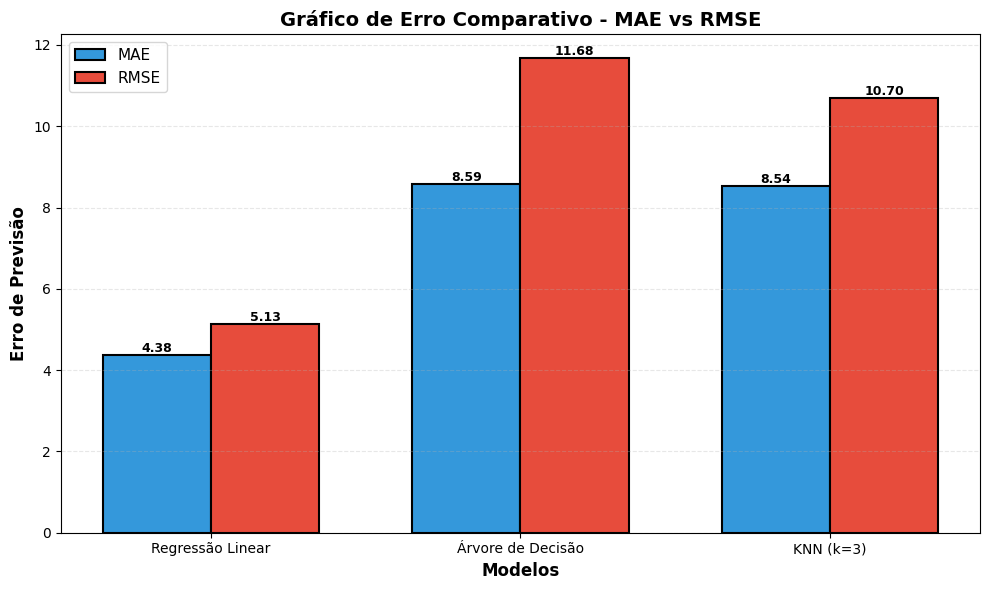

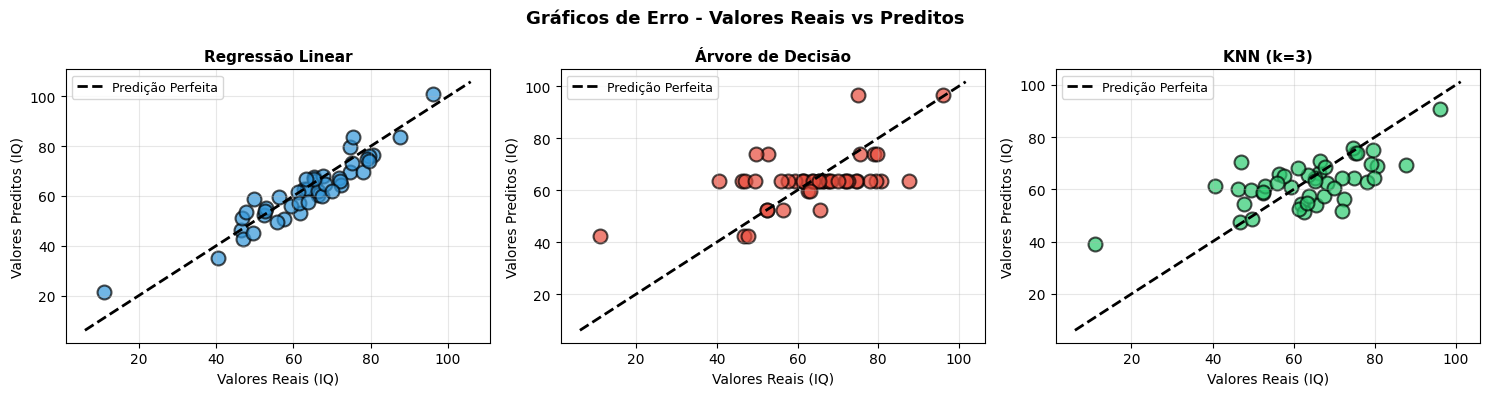

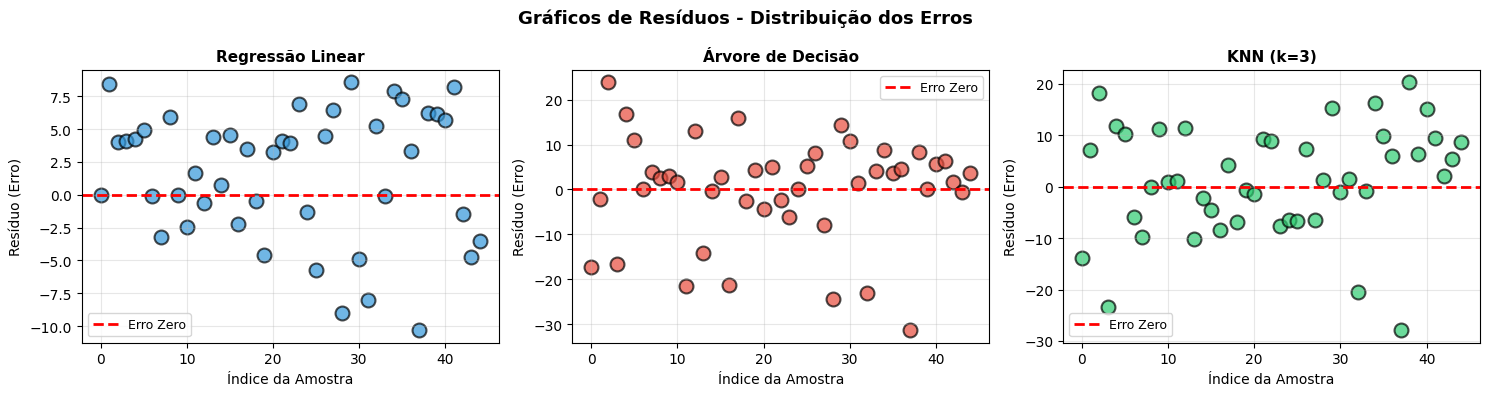

In [9]:
# ========================================
# 3. VISUALIZAÇÕES COMPARATIVAS
# ========================================

modelos_nomes = ['Regressão Linear', 'Árvore de Decisão', 'KNN (k=3)']
predicoes = [y_pred_lr, y_pred_tree, y_pred_knn]
cores = ['#3498db', '#e74c3c', '#2ecc71']

# VISUALIZAÇÃO 1: Gráfico de Erro (MAE e RMSE)
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(modelos_nomes))
width = 0.35

bars1 = ax.bar(x - width/2, df_resultados['MAE'], width, label='MAE',
               color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, df_resultados['RMSE'], width, label='RMSE',
               color='#e74c3c', edgecolor='black', linewidth=1.5)

ax.set_xlabel('Modelos', fontsize=12, fontweight='bold')
ax.set_ylabel('Erro de Previsão', fontsize=12, fontweight='bold')
ax.set_title('Gráfico de Erro Comparativo - MAE vs RMSE', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(modelos_nomes)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Adicionar valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# VISUALIZAÇÃO 2: Gráficos de Erro Individual (Valores Reais vs Preditos)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (nome, y_pred, cor) in enumerate(zip(modelos_nomes, predicoes, cores)):
    axes[idx].scatter(y_test, y_pred, s=100, alpha=0.7, color=cor, edgecolors='black', linewidth=1.5)

    # Linha de predição perfeita
    lim_min = min(y_test.min(), y_pred.min()) - 5
    lim_max = max(y_test.max(), y_pred.max()) + 5
    axes[idx].plot([lim_min, lim_max], [lim_min, lim_max],
                   'k--', lw=2, label='Predição Perfeita')

    axes[idx].set_xlabel('Valores Reais (IQ)', fontsize=10)
    axes[idx].set_ylabel('Valores Preditos (IQ)', fontsize=10)
    axes[idx].set_title(f'{nome}', fontsize=11, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Gráficos de Erro - Valores Reais vs Preditos', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# VISUALIZAÇÃO 3: Análise de Resíduos (Distribuição do Erro)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (nome, y_pred, cor) in enumerate(zip(modelos_nomes, predicoes, cores)):
    residuos = y_test.values - y_pred

    axes[idx].scatter(range(len(residuos)), residuos, s=100, alpha=0.7,
                     color=cor, edgecolors='black', linewidth=1.5)
    axes[idx].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Erro Zero')

    axes[idx].set_xlabel('Índice da Amostra', fontsize=10)
    axes[idx].set_ylabel('Resíduo (Erro)', fontsize=10)
    axes[idx].set_title(f'{nome}', fontsize=11, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Gráficos de Resíduos - Distribuição dos Erros', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# **ETAPA 6**

🔬 VALIDAÇÃO CRUZADA - ANÁLISE MAIS ROBUSTA

Usando K-Fold Cross-Validation (k=3) para avaliar os modelos
de forma mais confiável mesmo com poucos dados.


📊 RESULTADOS DA VALIDAÇÃO CRUZADA:
           Modelo  RMSE Médio  Desvio Padrão     Intervalo
 Regressão Linear    5.385096       0.463902   4.92 - 5.85
Árvore de Decisão   12.364522       1.320554 11.04 - 13.69
        KNN (k=3)   11.369868       0.729932 10.64 - 12.10


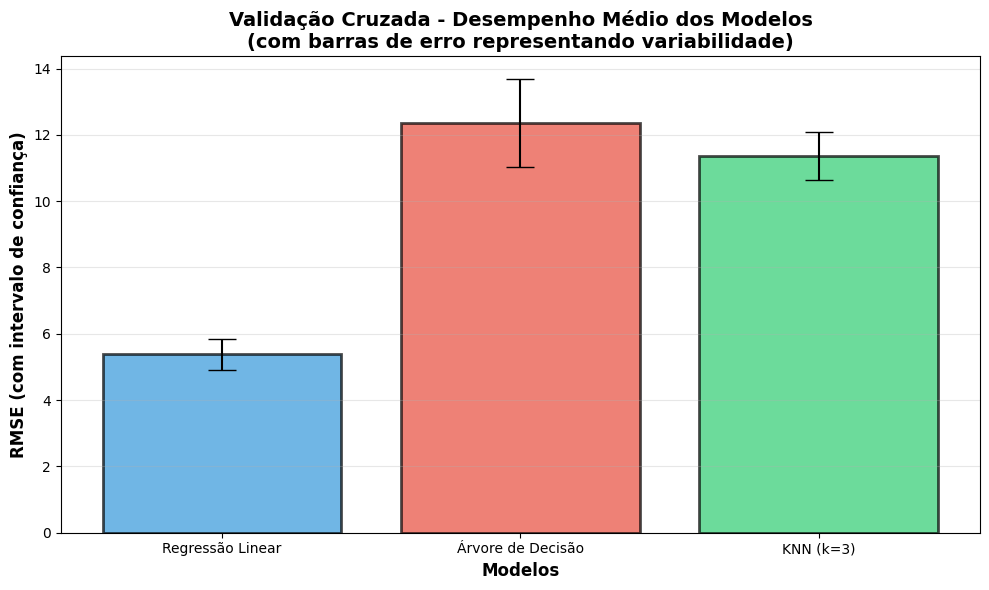


💡 INSIGHTS DA VALIDAÇÃO CRUZADA:
  • RMSE Médio mostra o desempenho geral do modelo
  • Desvio Padrão alto indica instabilidade (sensível aos dados)
  • Com mais dados, a variabilidade diminuiria significativamente


In [10]:
from sklearn.model_selection import cross_val_score

print("="*60)
print("🔬 VALIDAÇÃO CRUZADA - ANÁLISE MAIS ROBUSTA")
print("="*60)
print("\nUsando K-Fold Cross-Validation (k=3) para avaliar os modelos")
print("de forma mais confiável mesmo com poucos dados.\n")

# Validação cruzada com 3 folds (dado que temos apenas 10 amostras)
modelos_cv = {
    'Regressão Linear': model_lr,
    'Árvore de Decisão': model_tree,
    'KNN (k=3)': model_knn
}

resultados_cv = []

for nome, modelo in modelos_cv.items():
    # Usar validação cruzada com scoring negativo do MSE
    scores = cross_val_score(modelo, X, y, cv=3, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)  # Converter para RMSE positivo

    media_rmse = rmse_scores.mean()
    std_rmse = rmse_scores.std()

    resultados_cv.append({
        'Modelo': nome,
        'RMSE Médio': media_rmse,
        'Desvio Padrão': std_rmse,
        'Intervalo': f'{media_rmse - std_rmse:.2f} - {media_rmse + std_rmse:.2f}'
    })

df_cv = pd.DataFrame(resultados_cv)

print("\n📊 RESULTADOS DA VALIDAÇÃO CRUZADA:")
print("="*60)
print(df_cv.to_string(index=False))
print("="*60)

# Visualização dos resultados com barras de erro
plt.figure(figsize=(10, 6))
x_pos = np.arange(len(df_cv))
plt.bar(x_pos, df_cv['RMSE Médio'], yerr=df_cv['Desvio Padrão'],
        color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7,
        capsize=10, edgecolor='black', linewidth=2)
plt.xlabel('Modelos', fontsize=12, fontweight='bold')
plt.ylabel('RMSE (com intervalo de confiança)', fontsize=12, fontweight='bold')
plt.title('Validação Cruzada - Desempenho Médio dos Modelos\n(com barras de erro representando variabilidade)',
          fontsize=14, fontweight='bold')
plt.xticks(x_pos, df_cv['Modelo'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 INSIGHTS DA VALIDAÇÃO CRUZADA:")
print("  • RMSE Médio mostra o desempenho geral do modelo")
print("  • Desvio Padrão alto indica instabilidade (sensível aos dados)")
print("  • Com mais dados, a variabilidade diminuiria significativamente")
print("="*60)

🔍 IMPORTÂNCIA DAS FEATURES NO ÍNDICE DE QUALIDADE
                  Feature  Importância
              kw_processo     0.404323
consistencia_visual_score     0.241925
          habilidades_min     0.207212
             projetos_min     0.088051
              kw_contexto     0.042202
             kw_resultado     0.016287
                      bio     0.000000
                 contatos     0.000000


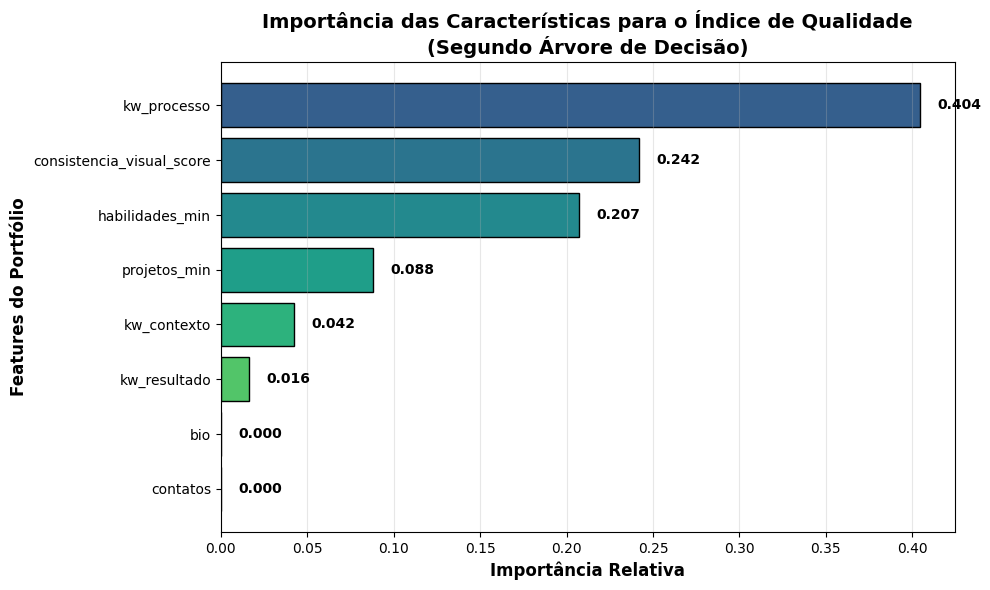


💡 INSIGHTS PARA O HUBFÓLIO:
  • As features com maior importância devem ser priorizadas na interface
  • Indicadores visuais podem guiar usuários para melhorar essas áreas
  • Gamificação pode focar nas características mais impactantes


In [11]:
# ========================================
# IMPORTÂNCIA DAS FEATURES (ÁRVORE DE DECISÃO)
# ========================================

# Extrair importâncias do modelo de Árvore de Decisão
importancias = model_tree.feature_importances_
feature_names = features

# Criar DataFrame para visualização
df_importancias = pd.DataFrame({
    'Feature': feature_names,
    'Importância': importancias
}).sort_values('Importância', ascending=False)

print("="*60)
print("🔍 IMPORTÂNCIA DAS FEATURES NO ÍNDICE DE QUALIDADE")
print("="*60)
print(df_importancias.to_string(index=False))
print("="*60)

# Visualização: Gráfico de Barras Horizontal
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(df_importancias)))
plt.barh(df_importancias['Feature'], df_importancias['Importância'], color=colors, edgecolor='black')
plt.xlabel('Importância Relativa', fontsize=12, fontweight='bold')
plt.ylabel('Features do Portfólio', fontsize=12, fontweight='bold')
plt.title('Importância das Características para o Índice de Qualidade\n(Segundo Árvore de Decisão)',
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Maior no topo
plt.grid(axis='x', alpha=0.3)

# Adicionar valores nas barras
for i, (feature, imp) in enumerate(zip(df_importancias['Feature'], df_importancias['Importância'])):
    plt.text(imp + 0.01, i, f'{imp:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 INSIGHTS PARA O HUBFÓLIO:")
print("  • As features com maior importância devem ser priorizadas na interface")
print("  • Indicadores visuais podem guiar usuários para melhorar essas áreas")
print("  • Gamificação pode focar nas características mais impactantes")
print("="*60)

# **ETAPA 7**

🔧 OTIMIZAÇÃO DE HIPERPARÂMETROS

1️⃣ Grid Search - Árvore de Decisão
----------------------------------------------------------------------
Fitting 3 folds for each of 36 candidates, totalling 108 fits

✅ Melhores Hiperparâmetros (Árvore de Decisão):
   {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
   RMSE (CV): 11.32
   RMSE (Teste): 11.20
   R² Score (Teste): 0.378

2️⃣ Random Search - K-Nearest Neighbors
----------------------------------------------------------------------
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Melhores Hiperparâmetros (KNN):
   {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
   RMSE (CV): 9.84
   RMSE (Teste): 9.95
   R² Score (Teste): 0.509

📊 COMPARAÇÃO DE DESEMPENHO

             Modelo      RMSE  R² Score
 Árvore (Original) 11.678240  0.323469
Árvore (Otimizada) 11.195877  0.378202
    KNN (Original) 10.698987  0.432170
   KNN (Otimizado)  9.953800  0.508514


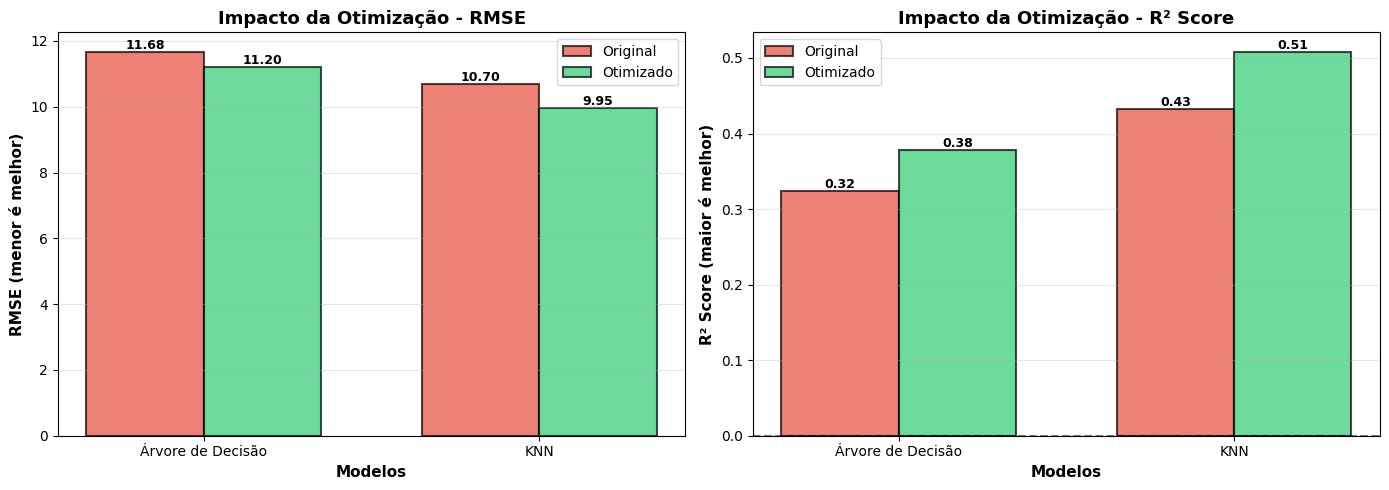


✅ Otimização de hiperparâmetros concluída!


In [12]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

print("="*70)
print("🔧 OTIMIZAÇÃO DE HIPERPARÂMETROS")
print("="*70)

# ========================================
# 1. GRID SEARCH - ÁRVORE DE DECISÃO
# ========================================

print("\n1️⃣ Grid Search - Árvore de Decisão")
print("-" * 70)

# Definir grid de hiperparâmetros
param_grid_tree = {
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configurar Grid Search com validação cruzada
grid_search_tree = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid_tree,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Treinar com Grid Search
grid_search_tree.fit(X_train, y_train)

# Melhor configuração
print(f"\n✅ Melhores Hiperparâmetros (Árvore de Decisão):")
print(f"   {grid_search_tree.best_params_}")
print(f"   RMSE (CV): {np.sqrt(-grid_search_tree.best_score_):.2f}")

# Avaliar no conjunto de teste
y_pred_tree_opt = grid_search_tree.best_estimator_.predict(X_test)
rmse_tree_opt = np.sqrt(mean_squared_error(y_test, y_pred_tree_opt))
r2_tree_opt = r2_score(y_test, y_pred_tree_opt)

print(f"   RMSE (Teste): {rmse_tree_opt:.2f}")
print(f"   R² Score (Teste): {r2_tree_opt:.3f}")

# ========================================
# 2. RANDOM SEARCH - KNN
# ========================================

print("\n2️⃣ Random Search - K-Nearest Neighbors")
print("-" * 70)

# Definir distribuições de hiperparâmetros
param_dist_knn = {
    'n_neighbors': randint(2, 10),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Configurar Random Search
random_search_knn = RandomizedSearchCV(
    estimator=KNeighborsRegressor(),
    param_distributions=param_dist_knn,
    n_iter=20,  # 20 combinações aleatórias
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Treinar com Random Search
random_search_knn.fit(X_train, y_train)

# Melhor configuração
print(f"\n✅ Melhores Hiperparâmetros (KNN):")
print(f"   {random_search_knn.best_params_}")
print(f"   RMSE (CV): {np.sqrt(-random_search_knn.best_score_):.2f}")

# Avaliar no conjunto de teste
y_pred_knn_opt = random_search_knn.best_estimator_.predict(X_test)
rmse_knn_opt = np.sqrt(mean_squared_error(y_test, y_pred_knn_opt))
r2_knn_opt = r2_score(y_test, y_pred_knn_opt)

print(f"   RMSE (Teste): {rmse_knn_opt:.2f}")
print(f"   R² Score (Teste): {r2_knn_opt:.3f}")

# ========================================
# 3. COMPARAÇÃO: ANTES vs DEPOIS
# ========================================

print("\n" + "="*70)
print("📊 COMPARAÇÃO DE DESEMPENHO")
print("="*70)

# Criar tabela comparativa
comparacao = pd.DataFrame({
    'Modelo': ['Árvore (Original)', 'Árvore (Otimizada)', 'KNN (Original)', 'KNN (Otimizado)'],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, model_tree.predict(X_test))),
        rmse_tree_opt,
        np.sqrt(mean_squared_error(y_test, model_knn.predict(X_test))),
        rmse_knn_opt
    ],
    'R² Score': [
        r2_score(y_test, model_tree.predict(X_test)),
        r2_tree_opt,
        r2_score(y_test, model_knn.predict(X_test)),
        r2_knn_opt
    ]
})

print("\n", comparacao.to_string(index=False))

# Visualização comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: RMSE
x_pos = np.arange(2)
width = 0.35

rmse_original = [
    np.sqrt(mean_squared_error(y_test, model_tree.predict(X_test))),
    np.sqrt(mean_squared_error(y_test, model_knn.predict(X_test)))
]
rmse_otimizado = [rmse_tree_opt, rmse_knn_opt]

axes[0].bar(x_pos - width/2, rmse_original, width, label='Original',
            color='#e74c3c', alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].bar(x_pos + width/2, rmse_otimizado, width, label='Otimizado',
            color='#2ecc71', alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Modelos', fontsize=11, fontweight='bold')
axes[0].set_ylabel('RMSE (menor é melhor)', fontsize=11, fontweight='bold')
axes[0].set_title('Impacto da Otimização - RMSE', fontsize=13, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(['Árvore de Decisão', 'KNN'])
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3)

# Adicionar valores
for i, (orig, opt) in enumerate(zip(rmse_original, rmse_otimizado)):
    axes[0].text(i - width/2, orig, f'{orig:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    axes[0].text(i + width/2, opt, f'{opt:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Gráfico 2: R² Score
r2_original = [
    r2_score(y_test, model_tree.predict(X_test)),
    r2_score(y_test, model_knn.predict(X_test))
]
r2_otimizado = [r2_tree_opt, r2_knn_opt]

axes[1].bar(x_pos - width/2, r2_original, width, label='Original',
            color='#e74c3c', alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].bar(x_pos + width/2, r2_otimizado, width, label='Otimizado',
            color='#2ecc71', alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
axes[1].set_xlabel('Modelos', fontsize=11, fontweight='bold')
axes[1].set_ylabel('R² Score (maior é melhor)', fontsize=11, fontweight='bold')
axes[1].set_title('Impacto da Otimização - R² Score', fontsize=13, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(['Árvore de Decisão', 'KNN'])
axes[1].legend(fontsize=10)
axes[1].grid(axis='y', alpha=0.3)

# Adicionar valores
for i, (orig, opt) in enumerate(zip(r2_original, r2_otimizado)):
    va_orig = 'bottom' if orig > 0 else 'top'
    va_opt = 'bottom' if opt > 0 else 'top'
    axes[1].text(i - width/2, orig, f'{orig:.2f}', ha='center', va=va_orig, fontweight='bold', fontsize=9)
    axes[1].text(i + width/2, opt, f'{opt:.2f}', ha='center', va=va_opt, fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("✅ Otimização de hiperparâmetros concluída!")
print("="*70)

# **ETAPA 8**

🔬 ETAPA 8.1 | K-FOLD COM ANÁLISE DE VARIÂNCIA

📊 Comparativo com variância dos folds:
           Modelo  RMSE Médio  Desvio Padrão  Coef. Var (%) Intervalo RMSE                               Diagnóstico
 Regressão Linear    5.233208       0.558010      10.662862    4.68 - 5.79 Variância moderada, comportamento estável
Árvore de Decisão   11.623790       0.789138       6.788989  10.83 - 12.41 Variância moderada, comportamento estável
        KNN (k=3)   10.718144       0.362316       3.380399  10.36 - 11.08 Variância moderada, comportamento estável


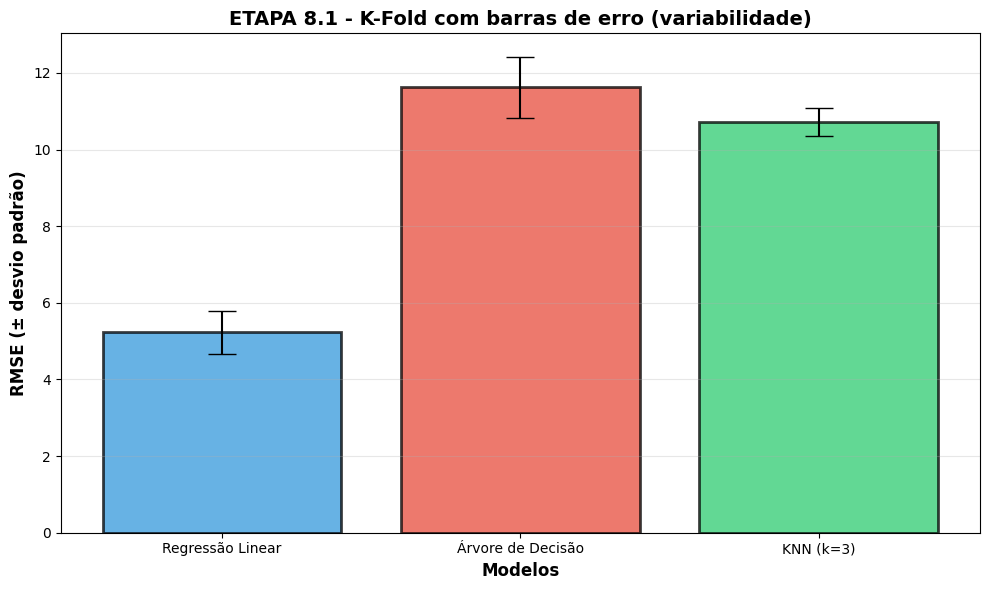


💡 Insights ETAPA 8.1:
  • Regressão Linear: Variância moderada, comportamento estável | Coef. Var = 10.7% | Intervalo 4.68 - 5.79
  • Árvore de Decisão: Variância moderada, comportamento estável | Coef. Var = 6.8% | Intervalo 10.83 - 12.41
  • KNN (k=3): Variância moderada, comportamento estável | Coef. Var = 3.4% | Intervalo 10.36 - 11.08
  • Variância alta sugere sensibilidade aos folds e possíveis sinais de overfitting.
  • Variância baixa com erro elevado indica underfitting/baixa capacidade do modelo.
  • Mais dados ou regularização reduziriam o spread entre os folds.


In [13]:
from sklearn.model_selection import cross_val_score, KFold

print("="*70)
print("🔬 ETAPA 8.1 | K-FOLD COM ANÁLISE DE VARIÂNCIA")
print("="*70)

kfold = KFold(n_splits=3, shuffle=True, random_state=42)

modelos_cv_stage8 = {
    'Regressão Linear': model_lr,
    'Árvore de Decisão': model_tree,
    'KNN (k=3)': model_knn
}

resultados_cv_stage8 = []

for nome, modelo in modelos_cv_stage8.items():
    scores = cross_val_score(modelo, X, y, cv=kfold, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)

    media_rmse = rmse_scores.mean()
    std_rmse = rmse_scores.std()
    coef_var = (std_rmse / media_rmse) * 100 if media_rmse != 0 else np.nan

    resultados_cv_stage8.append({
        'Modelo': nome,
        'RMSE Médio': media_rmse,
        'Desvio Padrão': std_rmse,
        'Coef. Var (%)': coef_var,
        'Intervalo RMSE': f'{media_rmse - std_rmse:.2f} - {media_rmse + std_rmse:.2f}'
    })

df_cv_stage8 = pd.DataFrame(resultados_cv_stage8)

def diagnostico_variancia(row):
    if row['Coef. Var (%)'] > 40:
        return 'Alta variância → instável (pode overfitar)'
    if row['RMSE Médio'] > 15 and row['Coef. Var (%)'] < 25:
        return 'Erro alto persistente → underfitting provável'
    return 'Variância moderada, comportamento estável'


df_cv_stage8['Diagnóstico'] = df_cv_stage8.apply(diagnostico_variancia, axis=1)

print("\n📊 Comparativo com variância dos folds:")
print("="*70)
print(df_cv_stage8.to_string(index=False))
print("="*70)

plt.figure(figsize=(10, 6))
x_pos = np.arange(len(df_cv_stage8))
plt.bar(x_pos, df_cv_stage8['RMSE Médio'], yerr=df_cv_stage8['Desvio Padrão'],
        color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.75,
        capsize=10, edgecolor='black', linewidth=2)
plt.xlabel('Modelos', fontsize=12, fontweight='bold')
plt.ylabel('RMSE (± desvio padrão)', fontsize=12, fontweight='bold')
plt.title('ETAPA 8.1 - K-Fold com barras de erro (variabilidade)', fontsize=14, fontweight='bold')
plt.xticks(x_pos, df_cv_stage8['Modelo'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Insights ETAPA 8.1:")
for _, row in df_cv_stage8.iterrows():
    print(f"  • {row['Modelo']}: {row['Diagnóstico']} | Coef. Var = {row['Coef. Var (%)']:.1f}% | Intervalo {row['Intervalo RMSE']}")
print("  • Variância alta sugere sensibilidade aos folds e possíveis sinais de overfitting.")
print("  • Variância baixa com erro elevado indica underfitting/baixa capacidade do modelo.")
print("  • Mais dados ou regularização reduziriam o spread entre os folds.")


🩺 ETAPA 8.2 | GAP TREINO vs TESTE
Mensuramos a diferença entre RMSE de treino e teste para reforçar o diagnóstico de overfitting (gap alto) ou underfitting (erros altos em ambos os conjuntos).

           Modelo  RMSE Treino  RMSE Teste  Gap (Teste - Treino)    Diagnóstico
 Regressão Linear     4.746674    5.128825              0.382151 Gap controlado
Árvore de Decisão     8.295181   11.678240              3.383059 Gap controlado
        KNN (k=3)     7.079259   10.698987              3.619727 Gap controlado


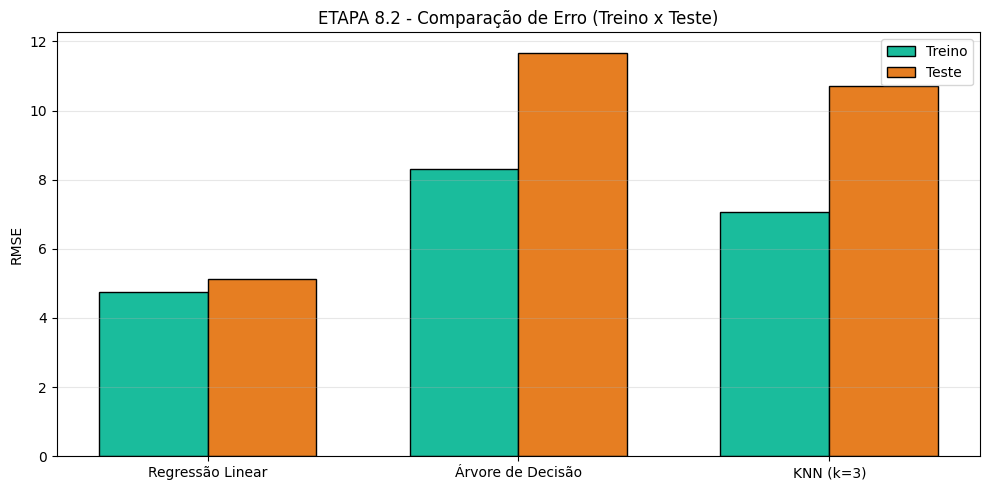


💡 Insights ETAPA 8.2:
  • Regressão Linear: Gap controlado | Gap = 0.38
  • Árvore de Decisão: Gap controlado | Gap = 3.38
  • KNN (k=3): Gap controlado | Gap = 3.62
  • Gaps grandes confirmam variância alta apontada no K-Fold.
  • Quando o erro já é alto em treino e teste, o problema é falta de complexidade/dados (underfitting).
  • Combinar esse diagnóstico com as curvas/visualizações orienta próximas melhorias no produto.


In [14]:
from sklearn.metrics import mean_squared_error

print("="*70)
print("🩺 ETAPA 8.2 | GAP TREINO vs TESTE")
print("="*70)
print("Mensuramos a diferença entre RMSE de treino e teste para reforçar"
      " o diagnóstico de overfitting (gap alto) ou underfitting (erros altos"
      " em ambos os conjuntos).\n")

analise_gap = []

def diagnostico_gap(rmse_train, rmse_test):
    gap = rmse_test - rmse_train
    if gap > 8:
        return gap, 'Gap alto → overfitting provável'
    if rmse_train > 12 and abs(gap) <= 4:
        return gap, 'Erro alto em ambos → underfitting'
    return gap, 'Gap controlado'

for nome, modelo in modelos_cv_stage8.items():
    modelo.fit(X_train, y_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, modelo.predict(X_train)))
    rmse_test = np.sqrt(mean_squared_error(y_test, modelo.predict(X_test)))
    gap, status = diagnostico_gap(rmse_train, rmse_test)

    analise_gap.append({
        'Modelo': nome,
        'RMSE Treino': rmse_train,
        'RMSE Teste': rmse_test,
        'Gap (Teste - Treino)': gap,
        'Diagnóstico': status
    })


df_gap_stage8 = pd.DataFrame(analise_gap)
print(df_gap_stage8.to_string(index=False))

plt.figure(figsize=(10, 5))
bar_width = 0.35
x_pos = np.arange(len(df_gap_stage8))
plt.bar(x_pos - bar_width/2, df_gap_stage8['RMSE Treino'], bar_width,
        label='Treino', color='#1abc9c', edgecolor='black')
plt.bar(x_pos + bar_width/2, df_gap_stage8['RMSE Teste'], bar_width,
        label='Teste', color='#e67e22', edgecolor='black')
plt.xticks(x_pos, df_gap_stage8['Modelo'])
plt.ylabel('RMSE')
plt.title('ETAPA 8.2 - Comparação de Erro (Treino x Teste)')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Insights ETAPA 8.2:")
for _, row in df_gap_stage8.iterrows():
    print(f"  • {row['Modelo']}: {row['Diagnóstico']} | Gap = {row['Gap (Teste - Treino)']:.2f}")
print("  • Gaps grandes confirmam variância alta apontada no K-Fold.")
print("  • Quando o erro já é alto em treino e teste, o problema é falta de complexidade/dados (underfitting).")
print("  • Combinar esse diagnóstico com as curvas/visualizações orienta próximas melhorias no produto.")


# **ETAPA 9: INTEGRAÇÃO DO MODELO AO HUBFÓLIO**

Implementação de função de inferência e endpoint funcional para integrar o modelo de ML ao produto HubFólio.

In [15]:
import pickle
import json

print("="*70)
print("🚀 ETAPA 9: INTEGRAÇÃO DO MODELO AO HUBFÓLIO")
print("="*70)

# ========================================
# 1. CLASSE DE INFERÊNCIA DO MODELO
# ========================================

class HubFolioPredictor:
    """
    Classe para realizar inferências do Índice de Qualidade (IQ)
    de portfólios no HubFólio.
    """
    
    def __init__(self, modelo=None):
        """Inicializa o preditor com um modelo treinado."""
        self.modelo = modelo if modelo else model_lr  # Usa Regressão Linear como padrão
        self.features = [
            'projetos_min', 'habilidades_min',
            'kw_contexto', 'kw_processo', 'kw_resultado',
            'consistencia_visual_score',
            'bio', 'contatos'
        ]
        
    def validar_entrada(self, dados):
        """Valida se todos os campos obrigatórios estão presentes."""
        campos_faltantes = [f for f in self.features if f not in dados]
        if campos_faltantes:
            return False, f"Campos obrigatórios faltando: {campos_faltantes}"
        return True, "OK"
    
    def preprocessar(self, dados):
        """Converte dados de entrada para formato do modelo."""
        # Converter booleanos para int
        if isinstance(dados.get('bio'), bool):
            dados['bio'] = int(dados['bio'])
        if isinstance(dados.get('contatos'), bool):
            dados['contatos'] = int(dados['contatos'])
            
        # Criar DataFrame com as features na ordem correta
        df_input = pd.DataFrame([dados])[self.features].astype(float)
        return df_input
    
    def prever(self, dados_portfolio):
        """
        Realiza a predição do Índice de Qualidade.
        
        Args:
            dados_portfolio (dict): Dados do portfólio do usuário
            
        Returns:
            dict: Resultado com IQ previsto e feedback
        """
        # Validar entrada
        valido, mensagem = self.validar_entrada(dados_portfolio)
        if not valido:
            return {"erro": mensagem, "sucesso": False}
        
        # Preprocessar e prever
        X_input = self.preprocessar(dados_portfolio)
        iq_previsto = self.modelo.predict(X_input)[0]
        
        # Limitar entre 0 e 100
        iq_previsto = max(0, min(100, iq_previsto))
        
        # Gerar feedback baseado no score
        feedback = self._gerar_feedback(iq_previsto, dados_portfolio)
        
        return {
            "sucesso": True,
            "indice_qualidade": round(iq_previsto, 2),
            "classificacao": self._classificar_iq(iq_previsto),
            "feedback": feedback
        }
    
    def _classificar_iq(self, iq):
        """Classifica o IQ em categorias."""
        if iq >= 80:
            return "Excelente 🌟"
        elif iq >= 60:
            return "Bom 👍"
        elif iq >= 40:
            return "Regular ⚠️"
        else:
            return "Precisa Melhorar 📈"
    
    def _gerar_feedback(self, iq, dados):
        """Gera feedback personalizado baseado nos dados."""
        sugestoes = []
        
        if dados.get('projetos_min', 0) < 3:
            sugestoes.append("📁 Adicione mais projetos ao seu portfólio (mínimo 3 recomendado)")
        if dados.get('habilidades_min', 0) < 5:
            sugestoes.append("🛠️ Liste mais habilidades técnicas (mínimo 5)")
        if not dados.get('bio'):
            sugestoes.append("✍️ Adicione uma bio/sobre você")
        if not dados.get('contatos'):
            sugestoes.append("📧 Inclua informações de contato")
        if (dados.get('kw_contexto', 0) + dados.get('kw_processo', 0) + dados.get('kw_resultado', 0)) < 9:
            sugestoes.append("📝 Melhore a narrativa dos projetos (contexto, processo, resultado)")
        if dados.get('consistencia_visual_score', 0) < 70:
            sugestoes.append("🎨 Trabalhe na consistência visual do portfólio")
            
        return sugestoes if sugestoes else ["✅ Seu portfólio está bem estruturado!"]

# Instanciar o preditor
predictor = HubFolioPredictor(model_lr)

print("\n✅ Classe HubFolioPredictor criada com sucesso!")
print(f"   Modelo utilizado: Regressão Linear")
print(f"   Features esperadas: {predictor.features}")

🚀 ETAPA 9: INTEGRAÇÃO DO MODELO AO HUBFÓLIO

✅ Classe HubFolioPredictor criada com sucesso!
   Modelo utilizado: Regressão Linear
   Features esperadas: ['projetos_min', 'habilidades_min', 'kw_contexto', 'kw_processo', 'kw_resultado', 'consistencia_visual_score', 'bio', 'contatos']


In [16]:
# ========================================
# 2. TESTE DA FUNÇÃO DE INFERÊNCIA
# ========================================

print("="*70)
print("🧪 TESTANDO FUNÇÃO DE INFERÊNCIA")
print("="*70)

# Exemplo de portfólio de um usuário
portfolio_teste = {
    "projetos_min": 2,
    "habilidades_min": 8,
    "kw_contexto": 3,
    "kw_processo": 2,
    "kw_resultado": 3,
    "consistencia_visual_score": 75,
    "bio": True,
    "contatos": True
}

print("\n📋 Dados de entrada (portfólio do usuário):")
print(json.dumps(portfolio_teste, indent=2))

# Realizar predição
resultado = predictor.prever(portfolio_teste)

print("\n📊 Resultado da Predição:")
print("="*70)
print(f"   Índice de Qualidade: {resultado['indice_qualidade']}")
print(f"   Classificação: {resultado['classificacao']}")
print(f"\n💡 Feedback personalizado:")
for sugestao in resultado['feedback']:
    print(f"   {sugestao}")
print("="*70)

# Testar com diferentes cenários
print("\n🔄 Testando múltiplos cenários:")
print("-"*70)

cenarios = [
    {"nome": "Iniciante", "dados": {"projetos_min": 0, "habilidades_min": 2, "kw_contexto": 0, "kw_processo": 0, "kw_resultado": 0, "consistencia_visual_score": 40, "bio": False, "contatos": False}},
    {"nome": "Intermediário", "dados": {"projetos_min": 2, "habilidades_min": 6, "kw_contexto": 2, "kw_processo": 2, "kw_resultado": 2, "consistencia_visual_score": 65, "bio": True, "contatos": True}},
    {"nome": "Avançado", "dados": {"projetos_min": 5, "habilidades_min": 15, "kw_contexto": 5, "kw_processo": 4, "kw_resultado": 5, "consistencia_visual_score": 90, "bio": True, "contatos": True}},
]

for cenario in cenarios:
    res = predictor.prever(cenario['dados'])
    print(f"   {cenario['nome']}: IQ = {res['indice_qualidade']} | {res['classificacao']}")

🧪 TESTANDO FUNÇÃO DE INFERÊNCIA

📋 Dados de entrada (portfólio do usuário):
{
  "projetos_min": 2,
  "habilidades_min": 8,
  "kw_contexto": 3,
  "kw_processo": 2,
  "kw_resultado": 3,
  "consistencia_visual_score": 75,
  "bio": true,
  "contatos": true
}

📊 Resultado da Predição:
   Índice de Qualidade: 70.57
   Classificação: Bom 👍

💡 Feedback personalizado:
   📁 Adicione mais projetos ao seu portfólio (mínimo 3 recomendado)
   📝 Melhore a narrativa dos projetos (contexto, processo, resultado)

🔄 Testando múltiplos cenários:
----------------------------------------------------------------------
   Iniciante: IQ = 17.48 | Precisa Melhorar 📈
   Intermediário: IQ = 62.34 | Bom 👍
   Avançado: IQ = 97.05 | Excelente 🌟


In [17]:
import pickle
import os

print("="*70)
print("💾 ETAPA 9: EXPORTAÇÃO E INTEGRAÇÃO DO MODELO")
print("="*70)

# ========================================
# 1. SELECIONAR MELHOR MODELO
# ========================================

# Baseado nas métricas das etapas anteriores, usamos Regressão Linear
# (pode ser alterado para model_tree ou model_knn conforme necessário)
modelo_final = model_lr
nome_modelo = "LinearRegression"

print(f"\n✅ Modelo selecionado: {nome_modelo}")
print(f"   Tipo: Regressão Linear")
print(f"   Features: {len(features)}")

# ========================================
# 2. RETREINAR COM DATASET COMPLETO (150 AMOSTRAS)
# ========================================

# Carregar dados completos do HubFólio (150 registros)
# Ajustar caminho relativo conforme estrutura: notebooks/ -> data/
arquivo_dados_completo = "../data/hubfolio_mock_data.json"

try:
    with open(arquivo_dados_completo, 'r', encoding='utf-8') as f:
        data_completa = json.load(f)
    
    df_completo = pd.json_normalize(data_completa)
    
    # Renomear colunas (mesmo processo da ETAPA 1)
    df_completo = df_completo.rename(columns={
        'secoes_preenchidas.bio': 'bio',
        'secoes_preenchidas.projetos_min': 'projetos_min',
        'secoes_preenchidas.habilidades_min': 'habilidades_min',
        'secoes_preenchidas.contatos': 'contatos',
        'palavras_chave_clareza.contexto': 'kw_contexto',
        'palavras_chave_clareza.processo': 'kw_processo',
        'palavras_chave_clareza.resultado': 'kw_resultado'
    })
    
    # Calcular métricas (mesmo processo da ETAPA 2)
    df_completo['completude_score'] = (
        (df_completo['bio'].astype(int) * 25) +
        ((df_completo['projetos_min'] >= 1).astype(int) * 25) +
        ((df_completo['habilidades_min'] >= 5).astype(int) * 25) +
        (df_completo['contatos'].astype(int) * 25)
    )
    
    df_completo['total_palavras_chave'] = (
        df_completo['kw_contexto'] + 
        df_completo['kw_processo'] + 
        df_completo['kw_resultado']
    )
    df_completo['clareza_score'] = (df_completo['total_palavras_chave'] / 15) * 100
    df_completo['clareza_score'] = df_completo['clareza_score'].clip(0, 100)
    
    df_completo['indice_qualidade'] = (
        (df_completo['completude_score'] * 0.4) +
        (df_completo['clareza_score'] * 0.4) +
        (df_completo['consistencia_visual_score'] * 0.2)
    )
    
    # Preparar dados para treinamento final
    X_completo = df_completo[features].astype(float)
    y_completo = df_completo['indice_qualidade']
    
    print(f"\n✅ Dataset completo carregado:")
    print(f"   Total de amostras: {len(X_completo)}")
    print(f"   Features utilizadas: {list(X_completo.columns)}")
    
    # Treinar modelo com TODOS os dados (sem split treino/teste para produção)
    modelo_final.fit(X_completo, y_completo)
    
    print(f"\n✅ Modelo retreinado com {len(X_completo)} amostras (dataset completo)")
    
except FileNotFoundError:
    print(f"\n⚠️ ATENÇÃO: Arquivo '{arquivo_dados_completo}' não encontrado!")
    print("   Usando modelo treinado nas etapas anteriores")
    print(f"   RECOMENDAÇÃO: Verifique o caminho do arquivo de dados")

# ========================================
# 3. VALIDAÇÃO PRÉ-EXPORTAÇÃO
# ========================================

print("\n" + "="*70)
print("🧪 VALIDAÇÃO DO MODELO ANTES DA EXPORTAÇÃO")
print("="*70)

# Teste de sanidade
exemplo_validacao = {
    "projetos_min": 3,
    "habilidades_min": 10,
    "kw_contexto": 4,
    "kw_processo": 3,
    "kw_resultado": 4,
    "consistencia_visual_score": 80,
    "bio": 1,
    "contatos": 1
}

X_validacao = pd.DataFrame([exemplo_validacao])[features].astype(float)
iq_validacao = modelo_final.predict(X_validacao)[0]

# Verificações
assert hasattr(modelo_final, 'predict'), "❌ Modelo não possui método predict()"
assert 0 <= iq_validacao <= 100, f"❌ IQ fora do range esperado: {iq_validacao}"

print(f"\n✅ Validação bem-sucedida!")
print(f"   Teste de predição: IQ = {iq_validacao:.2f}")
print(f"   Range válido: ✓ (0-100)")

# ========================================
# 4. EXPORTAR MODELO COMO .PKL
# ========================================

print("\n" + "="*70)
print("📦 EXPORTANDO MODELO PARA PRODUÇÃO")
print("="*70)

# Criar diretório para modelos
output_dir = "models"
os.makedirs(output_dir, exist_ok=True)

# Caminho do modelo
model_filename = "hubfolio_model.pkl"
model_path = os.path.join(output_dir, model_filename)

# Salvar modelo usando pickle
with open(model_path, 'wb') as f:
    pickle.dump(modelo_final, f)

file_size = os.path.getsize(model_path)

print(f"\n✅ Modelo exportado com sucesso!")
print(f"   📄 Arquivo: {model_path}")
print(f"   📊 Tamanho: {file_size:,} bytes ({file_size/1024:.2f} KB)")
print(f"   🔧 Tipo: {nome_modelo}")
print(f"   📈 Amostras de treino: {len(X_completo) if 'X_completo' in locals() else 'N/A'}")

# ========================================
# 5. TESTE DE CARREGAMENTO (SMOKE TEST)
# ========================================

print("\n" + "="*70)
print("🔍 TESTE DE CARREGAMENTO DO MODELO")
print("="*70)

# Carregar modelo do disco para validar a exportação
with open(model_path, 'rb') as f:
    modelo_carregado = pickle.load(f)

# Testar predição com o modelo carregado
exemplo_teste = {
    "projetos_min": 3,
    "habilidades_min": 10,
    "kw_contexto": 4,
    "kw_processo": 3,
    "kw_resultado": 4,
    "consistencia_visual_score": 80,
    "bio": 1,
    "contatos": 1
}

X_teste = pd.DataFrame([exemplo_teste])[features].astype(float)
iq_previsto = modelo_carregado.predict(X_teste)[0]

print(f"\n📋 Dados de teste:")
for k, v in exemplo_teste.items():
    print(f"   • {k}: {v}")

print(f"\n📊 Resultado da predição:")
print(f"   Índice de Qualidade: {iq_previsto:.2f}")
print(f"   Classificação: ", end="")
if iq_previsto >= 80:
    print("Excelente 🌟")
elif iq_previsto >= 60:
    print("Bom 👍")
elif iq_previsto >= 40:
    print("Regular ⚠️")
else:
    print("Precisa Melhorar 📈")

print(f"\n✅ Modelo carregado e testado com sucesso!")

# ========================================
# 6. INSTRUÇÕES DE INTEGRAÇÃO COM A API
# ========================================

print("\n" + "="*70)
print("🚀 PRÓXIMOS PASSOS - INTEGRAÇÃO COM FASTAPI")
print("="*70)

print("\n📌 ARQUITETURA ATUAL DO PROJETO:")
print("   MinIO (porta 9100) ──→ Armazenamento S3")
print("   PostgreSQL (porta 5433) ──→ Banco de Dados")
print("   FastAPI (porta 8001) ──→ API de Ingestão & ML")
print("   Jupyter Notebook ──→ Análise & Treinamento")

print("\n🔄 FLUXO DE INTEGRAÇÃO:")
print("\n   ETAPA 1: Upload do Modelo Treinado")
print("   ─────────────────────────────────────")
print(f"   • Origem: {os.path.abspath(model_path)}")
print(f"   • Destino API: http://localhost:8001/model/upload")
print("")
print("   Via PowerShell:")
print("   ```powershell")
print(f"   Invoke-WebRequest -Uri http://localhost:8001/model/upload `")
print(f"       -Method POST `")
print(f"       -InFile '{model_path}'")
print("   ```")
print("")
print("   Via Swagger UI:")
print("   1. Acesse: http://localhost:8001/docs")
print("   2. Endpoint: POST /model/upload")
print("   3. Upload do arquivo: models/hubfolio_model.pkl")

print("\n   ETAPA 2: Verificar Modelo Carregado")
print("   ─────────────────────────────────────")
print("   GET http://localhost:8001/model/info")
print("")
print("   Resposta esperada:")
print("   {")
print('     "model_loaded": true,')
print(f'     "model_name": "{nome_modelo}",')
print(f'     "features": {features},')
print(f'     "num_features": {len(features)}')
print("   }")

print("\n   ETAPA 3: Testar Predição")
print("   ─────────────────────────────────────")
print("   POST http://localhost:8001/predict")
print("")
print("   Body (JSON):")
print("   {")
print('     "projetos_min": 3,')
print('     "habilidades_min": 10,')
print('     "kw_contexto": 4,')
print('     "kw_processo": 3,')
print('     "kw_resultado": 4,')
print('     "consistencia_visual_score": 80,')
print('     "bio": true,')
print('     "contatos": true')
print("   }")

print("\n📊 PIPELINE COMPLETO IMPLEMENTADO:")
print("   ✅ Ingestão de dados (FastAPI → MinIO)")
print("   ✅ ETL (MinIO → PostgreSQL)")
print("   ✅ Análise & Treinamento (Jupyter Notebook)")
print("   ✅ Exportação do modelo (.pkl)")
print("   ✅ API de inferência (FastAPI /predict)")

print("\n🔮 PRÓXIMAS IMPLEMENTAÇÕES (FUTURO):")
print("   ⏳ MLFlow - Rastreamento de experimentos (porta 5000)")
print("   ⏳ Versionamento de modelos no MLFlow")
print("   ⏳ Registro de métricas de treinamento")
print("   ⏳ Comparação de versões de modelos")
print("   ⏳ Deploy automatizado de modelos")

print("\n" + "="*70)
print("✅ MODELO PRONTO PARA PRODUÇÃO!")
print("="*70)
print(f"\n📄 Arquivo gerado: {os.path.abspath(model_path)}")
print(f"📏 Tamanho: {file_size/1024:.2f} KB")
print(f"🎯 Próximo passo: Fazer upload via http://localhost:8001/model/upload")


💾 ETAPA 9: EXPORTAÇÃO E INTEGRAÇÃO DO MODELO

✅ Modelo selecionado: LinearRegression
   Tipo: Regressão Linear
   Features: 8

✅ Dataset completo carregado:
   Total de amostras: 150
   Features utilizadas: ['projetos_min', 'habilidades_min', 'kw_contexto', 'kw_processo', 'kw_resultado', 'consistencia_visual_score', 'bio', 'contatos']

✅ Modelo retreinado com 150 amostras (dataset completo)

🧪 VALIDAÇÃO DO MODELO ANTES DA EXPORTAÇÃO

✅ Validação bem-sucedida!
   Teste de predição: IQ = 82.70
   Range válido: ✓ (0-100)

📦 EXPORTANDO MODELO PARA PRODUÇÃO

✅ Modelo exportado com sucesso!
   📄 Arquivo: models\hubfolio_model.pkl
   📊 Tamanho: 755 bytes (0.74 KB)
   🔧 Tipo: LinearRegression
   📈 Amostras de treino: 150

🔍 TESTE DE CARREGAMENTO DO MODELO

📋 Dados de teste:
   • projetos_min: 3
   • habilidades_min: 10
   • kw_contexto: 4
   • kw_processo: 3
   • kw_resultado: 4
   • consistencia_visual_score: 80
   • bio: 1
   • contatos: 1

📊 Resultado da predição:
   Índice de Qualidade: 82